<a href="https://colab.research.google.com/github/Rodizo/CS231N-Standford/blob/main/Copy_of_PT2_Time_Series_Forecasting_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
import pandas as pd

df = pd.read_excel('processed_dataset.xlsx')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)


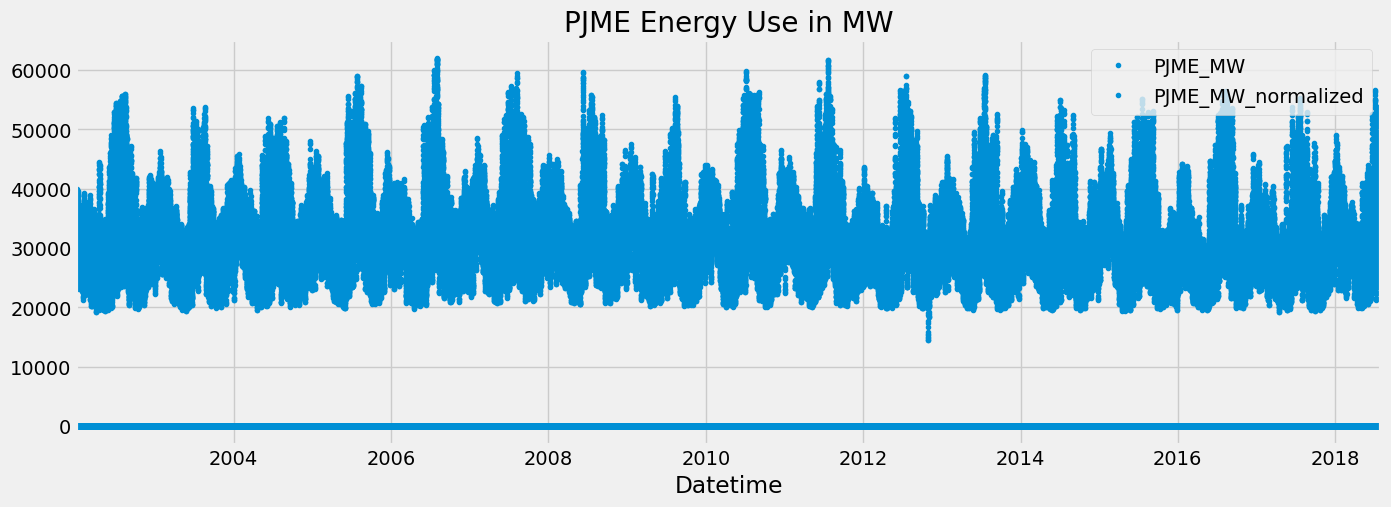

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

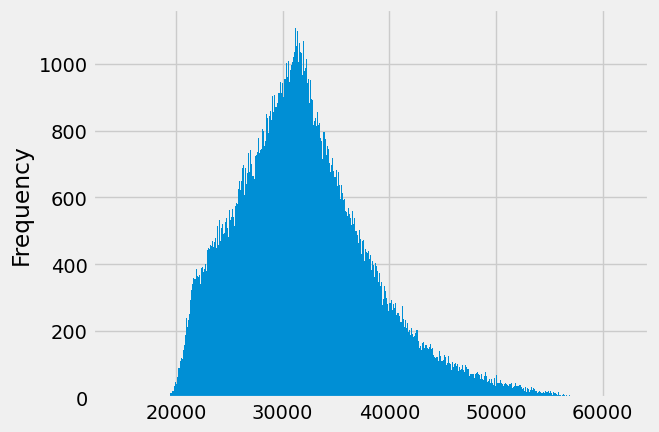

In [ ]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

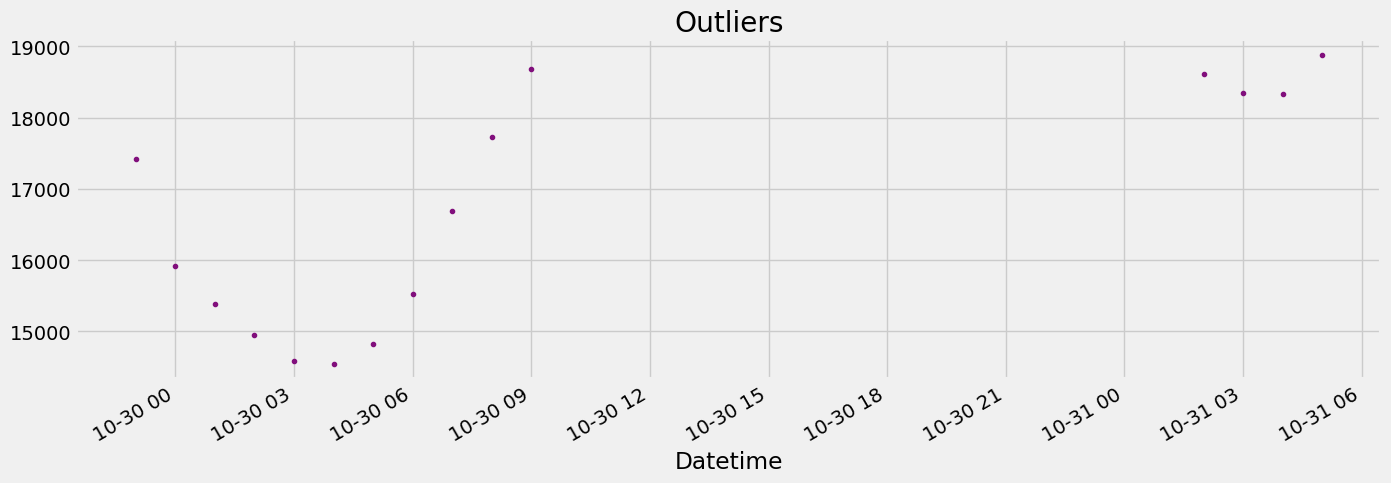

In [ ]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [ ]:
df = df.query('PJME_MW > 19_000').copy()

# Reviewing: Train / Test Split

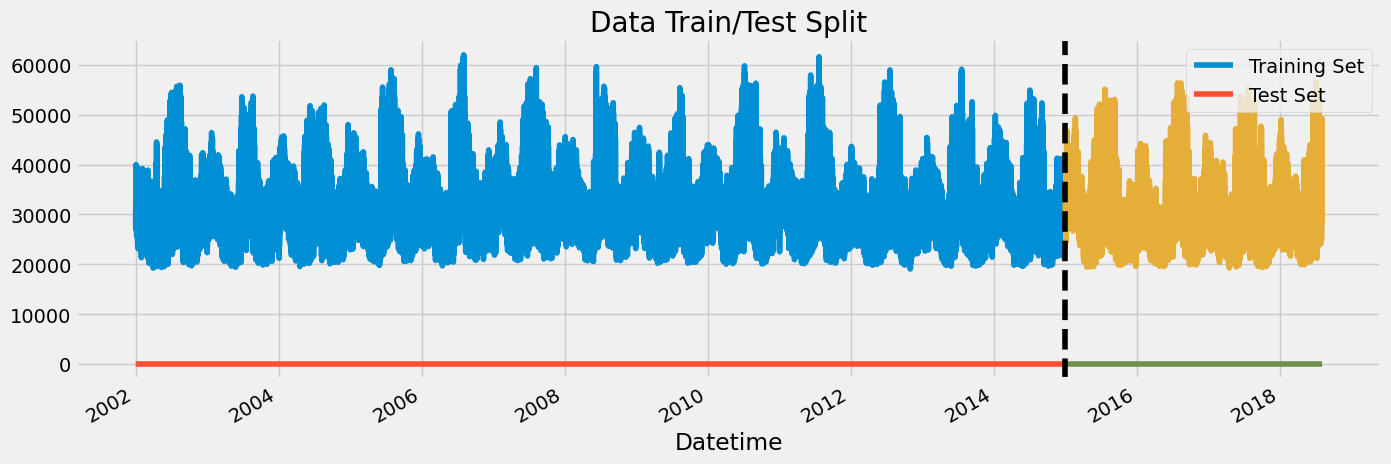

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# 1. Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=8, test_size=24*365*1, gap=24)
df = df.sort_index()

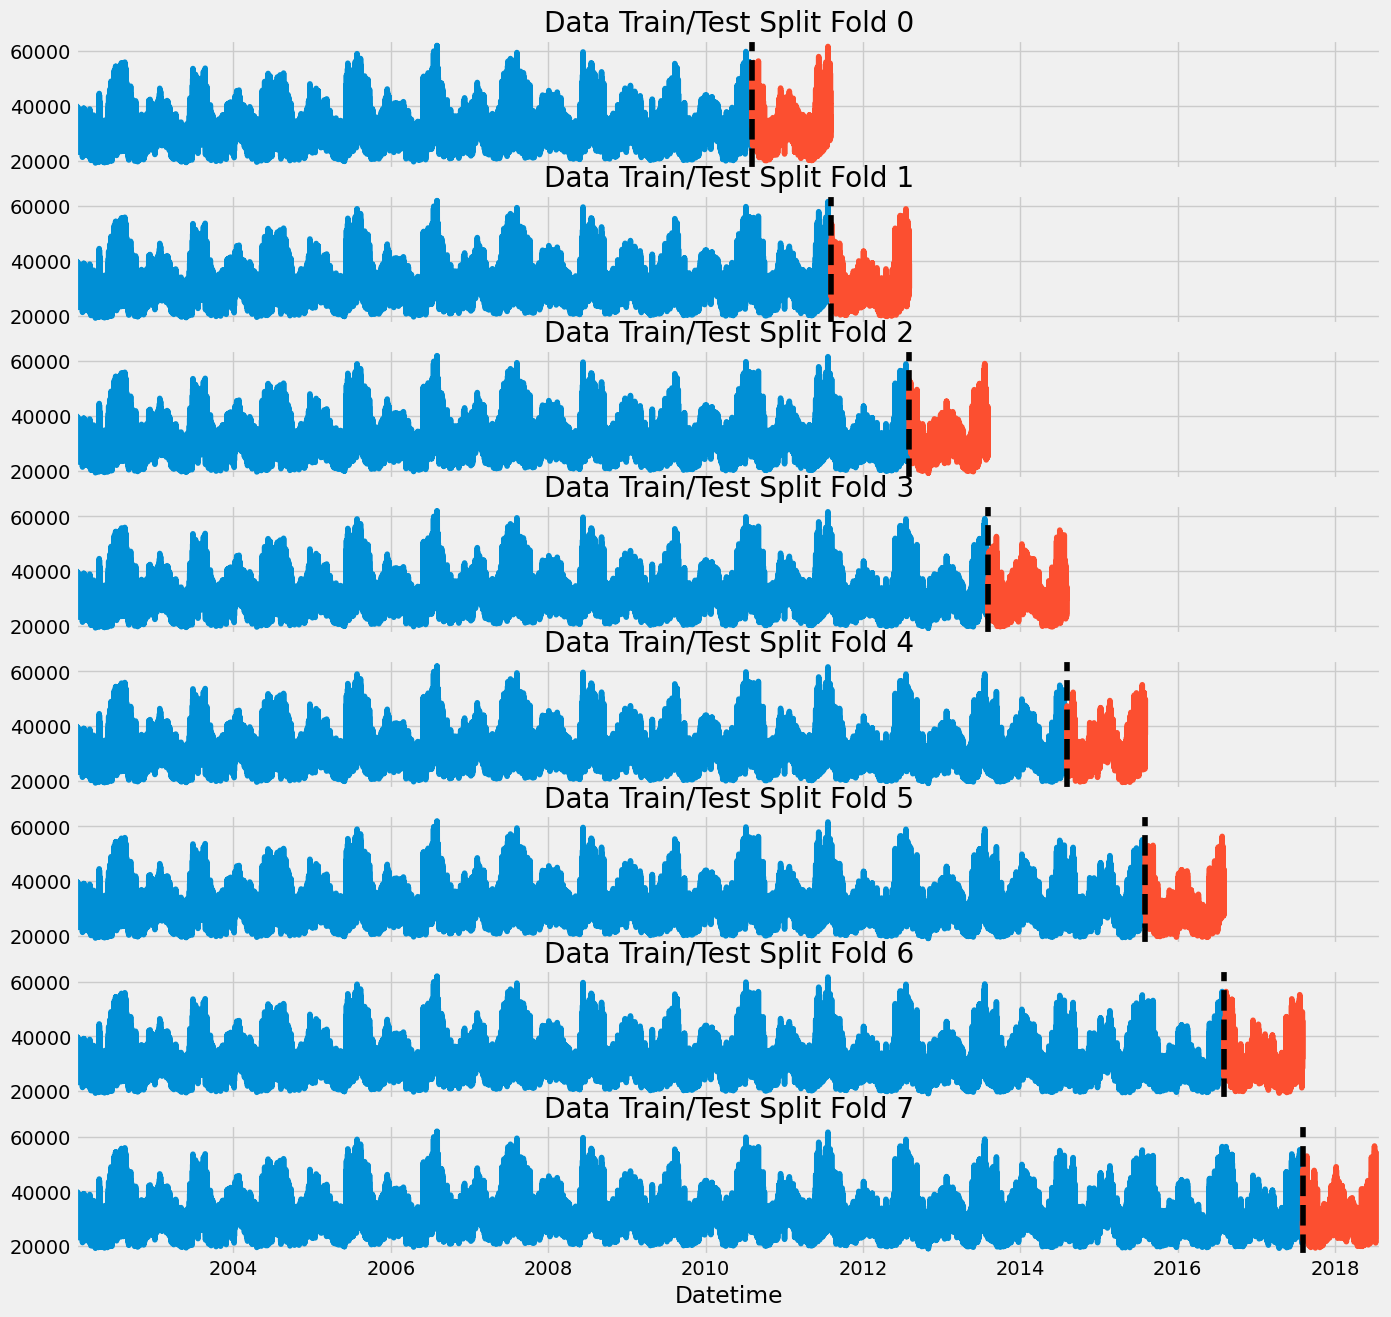

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# 3. Lag Features
- What was the target (x) days in the past.

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

## Train Using Cross Validation

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=6,  # Best value found
                       learning_rate=0.01,
                       colsample_bytree=1.0,  # Best value found
                       gamma=0.7854,  # Best value found
                       min_child_weight=2.117,  # Best value found
                       subsample=1.0)  # Best value found

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32729.57855	validation_1-rmse:31955.20950


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:47:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12400.79422	validation_1-rmse:12036.35392
[200]	validation_0-rmse:5387.16315	validation_1-rmse:5544.32332
[300]	validation_0-rmse:3370.07319	validation_1-rmse:4014.51632
[400]	validation_0-rmse:2900.79510	validation_1-rmse:3770.87387
[500]	validation_0-rmse:2716.82450	validation_1-rmse:3754.93666
[516]	validation_0-rmse:2696.92569	validation_1-rmse:3754.40878
[0]	validation_0-rmse:32669.28762	validation_1-rmse:32141.01146


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:47:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12388.70527	validation_1-rmse:12393.92542
[200]	validation_0-rmse:5407.78759	validation_1-rmse:5770.73588
[300]	validation_0-rmse:3410.93358	validation_1-rmse:3876.78956
[400]	validation_0-rmse:2959.51976	validation_1-rmse:3475.58820
[500]	validation_0-rmse:2779.47610	validation_1-rmse:3416.92662
[600]	validation_0-rmse:2672.97871	validation_1-rmse:3405.11192
[700]	validation_0-rmse:2594.58632	validation_1-rmse:3398.67445
[752]	validation_0-rmse:2559.08403	validation_1-rmse:3406.08378
[0]	validation_0-rmse:32628.52900	validation_1-rmse:31076.79898


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:47:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12375.98203	validation_1-rmse:11222.68588
[200]	validation_0-rmse:5413.24316	validation_1-rmse:4783.37594
[300]	validation_0-rmse:3431.88299	validation_1-rmse:3562.78610
[377]	validation_0-rmse:3039.22930	validation_1-rmse:3573.61490
[0]	validation_0-rmse:32525.84088	validation_1-rmse:31476.69479


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:48:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12339.71612	validation_1-rmse:12138.35052
[200]	validation_0-rmse:5411.61990	validation_1-rmse:5869.61292
[300]	validation_0-rmse:3439.59838	validation_1-rmse:4357.15584
[400]	validation_0-rmse:3002.96579	validation_1-rmse:4048.52280
[500]	validation_0-rmse:2827.80574	validation_1-rmse:3912.95093
[600]	validation_0-rmse:2724.55523	validation_1-rmse:3879.61408
[700]	validation_0-rmse:2645.77529	validation_1-rmse:3871.59364
[752]	validation_0-rmse:2611.01100	validation_1-rmse:3873.34689
[0]	validation_0-rmse:32459.75364	validation_1-rmse:31467.59903


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:48:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12328.49556	validation_1-rmse:12133.78089
[200]	validation_0-rmse:5433.89745	validation_1-rmse:5820.08747
[300]	validation_0-rmse:3485.32949	validation_1-rmse:4262.74954
[400]	validation_0-rmse:3050.82732	validation_1-rmse:3989.25248
[500]	validation_0-rmse:2888.77682	validation_1-rmse:3967.15701
[504]	validation_0-rmse:2884.32644	validation_1-rmse:3968.46354


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3702.6733
Fold scores:[3748.98340850011, 3397.9048667097118, 3535.778789776781, 3871.2731741148455, 3959.4264991818195]


# 4. Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=6,  # Best value found
                       learning_rate=0.01,
                       colsample_bytree=1.0,  # Best value found
                       gamma=0.7854,  # Best value found
                       min_child_weight=2.117,  # Best value found
                       subsample=1.0)  # Best value found

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32401.57310


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:48:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12313.65299
[200]	validation_0-rmse:5449.25028
[300]	validation_0-rmse:3523.54181
[400]	validation_0-rmse:3096.42015
[499]	validation_0-rmse:2919.70925


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.7854, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2.117, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

## Predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

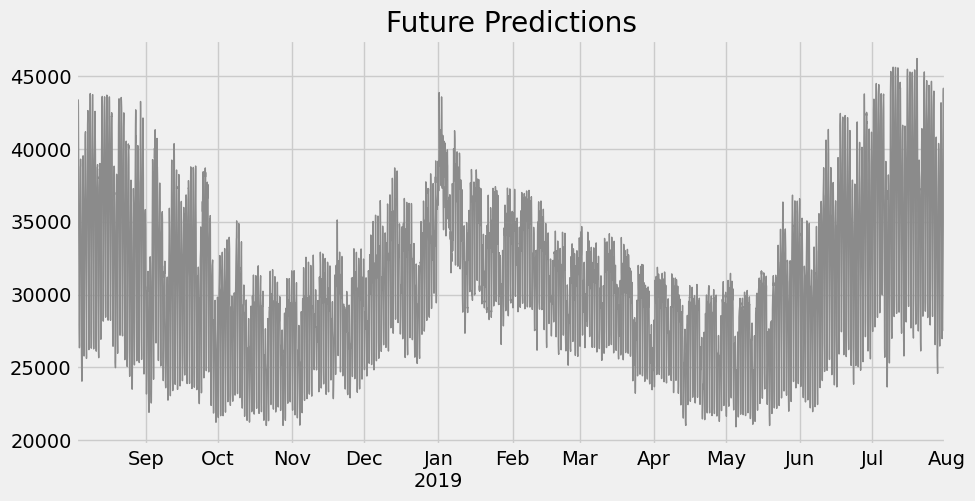

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# Bonus: Saving Model For later

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

total 7.2M
-rw-r--r-- 1 root root 3.3M Apr 15 14:49 model.json
-rw-r--r-- 1 root root 3.9M Apr 15 14:26 processed_dataset.xlsx
drwxr-xr-x 1 root root 4.0K Apr 11 13:21 sample_data


<Axes: title={'center': 'Future Predictions'}>

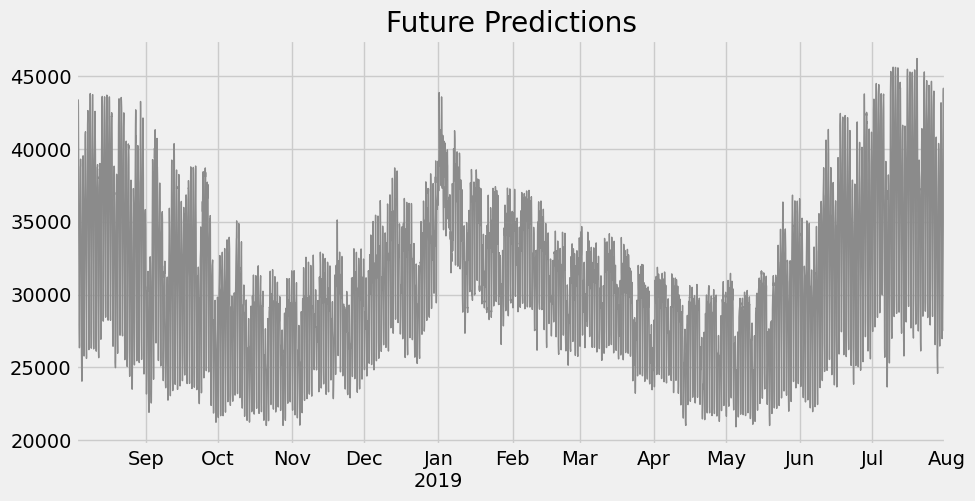

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

In [ ]:
pip install bayesian-optimization


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

# Example dataset loading and preprocessing
# Assuming 'df' is your DataFrame containing the time series data
# Assume df['y'] to be the target variable and df['features'] the inputs

# Generate features using a rolling window approach
window_size = 3  # Example window size
for i in range(1, window_size + 1):
    df[f'lag_{i}'] = df[TARGET].shift(i)

# Drop rows with NaN values caused by shifting
df = df.dropna()

# Define features and target
X = df[[f'lag_{i}' for i in range(1, window_size + 1)]]
y = df[TARGET]

def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, min_child_weight):
    params = {
        'eval_metric': 'rmse',
        'max_depth': int(max_depth),
        'subsample': subsample,
        'eta': 0.1,
        'gamma': gamma,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight
    }

    # Ensure to use TimeSeriesSplit for time series data
    cv = TimeSeriesSplit(n_splits=5)
    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(**params, objective='reg:squarederror')
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        cv_scores[idx] = mean_squared_error(y_test, predictions, squared=False)

    return -np.mean(cv_scores)  # Negative RMSE for maximization

TARGET = 'y'  # Assuming 'y' is your target variable

bounds = {
    'max_depth': (3, 10),
    'gamma': (0, 5),
    'colsample_bytree': (0.3, 1.0),
    'subsample': (0.4, 1.0),
    'min_child_weight': (1, 10)
}

optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=25)


|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | -1.948e+0 | 0.5622    | 4.754     | 8.124     | 6.388     | 0.4936    |
| 2         | -1.948e+0 | 0.4092    | 0.2904    | 9.063     | 6.41      | 0.8248    |
| 3         | -1.948e+0 | 0.3144    | 4.85      | 8.827     | 2.911     | 0.5091    |
| 4         | -1.94e+03 | 0.4284    | 1.521     | 6.673     | 4.888     | 0.5747    |
| 5         | -796.6    | 0.7283    | 0.6975    | 5.045     | 4.297     | 0.6736    |
| 6         | -763.3    | 0.8496    | 0.9984    | 6.6       | 6.332     | 0.4279    |
| 7         | -960.3    | 0.7253    | 0.8526    | 3.455     | 9.54      | 0.9794    |
| 8         | -958.1    | 0.8659    | 1.523     | 3.684     | 7.158     | 0.6641    |
| 9         | -1.943e+0 | 0.3854    | 2.476     | 3.241     | 9.184     | 0.5553    |
| 10        | -764.4    | 0.7638    | 1.559     | 6.64

# The End